# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [11]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

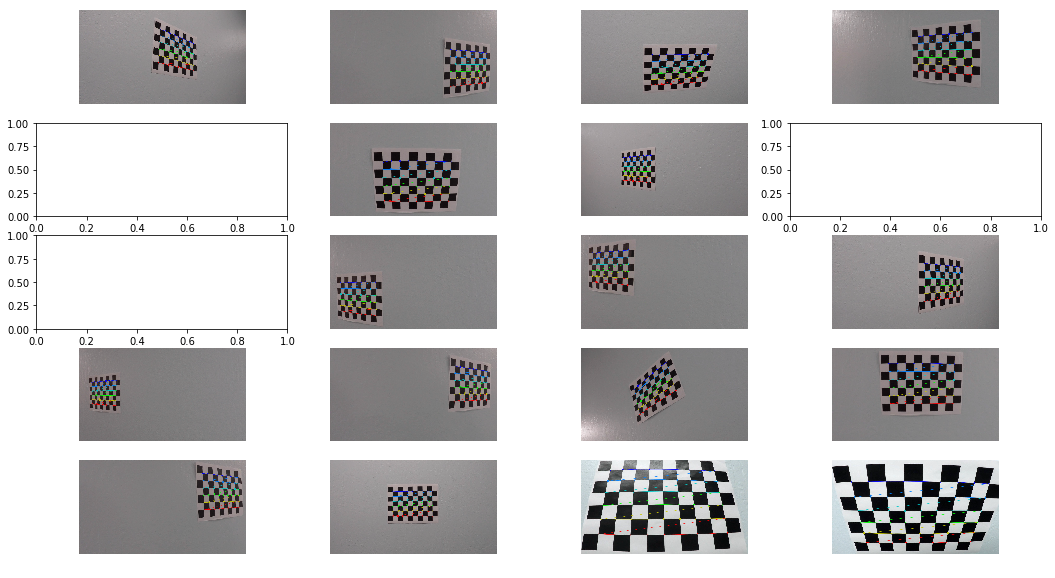

In [12]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# loading into the list of calibration images
imagess = glob.glob('./camera_cal/calibration*.jpg')
fig,axs=plt.subplots(5,4,figsize=(18,10))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs=axs.flatten()#to convert the array of images into 1-d
#jpg images follow BGR format
#x=0;
# Step through the list and search for chessboard corners
for i,fname in enumerate(imagess):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    #x=i;
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        axs[i].axis('off')
        axs[i].imshow(img)


# Looking how the distortion works

(720, 1280, 3)


Text(0.5,1,'undistorted image')

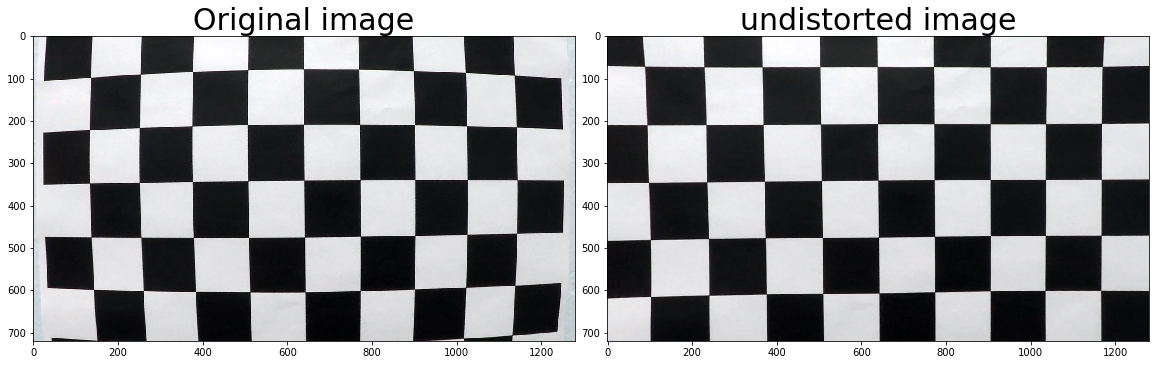

In [13]:
img=cv2.imread('./camera_cal/calibration1.jpg')
print(img.shape)
img_size=(img.shape[1],img.shape[0])

#performing camera calibration using above calclated obj points and img points 
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
dst = cv2.undistort(img, mtx, dist, None, mtx)
import pickle
#now save all these points into a dictionary for the future use 
dict_pickle={}
dict_pickle["mtx"]=mtx
dict_pickle["dist"]=dist
#making pickle file,and saving all calibration images in alibration.p/
pickle.dump(dict_pickle,open ("calibration.p","wb"))

#visualize the undistorted image 
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
fig.subplots_adjust(hspace=.3,wspace=.06)
ax1.imshow(img)
ax1.set_title('Original image',fontsize=30)
ax2.imshow(dst)
ax2.set_title('undistorted image',fontsize=30)


            



# Test  Image Example

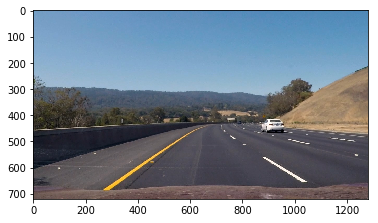

In [14]:
exam_img=cv2.imread('./test_images/test3.jpg')
#print(exam_img.shape)
#convert image into RGB from BGR
exam_img=cv2.cvtColor(exam_img,cv2.COLOR_BGR2RGB)
plt.imshow(exam_img)


# Undistort Image Function

In [15]:
def undistort(img):
    undist=cv2.undistort(img, mtx, dist, None, mtx)
    return undist

# Visulaize undistort image on test image

Text(0.5,1,'Undistorted Image')

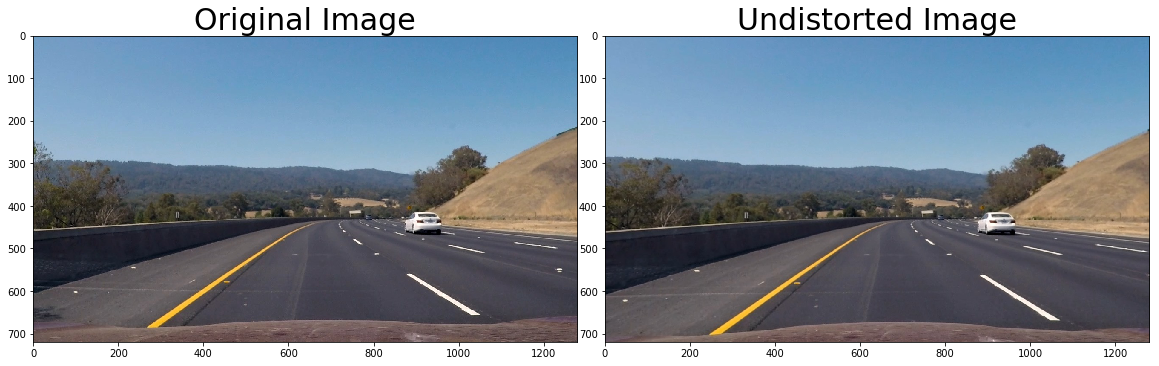

In [16]:

exampleImg_undistort = undistort(exam_img)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(exam_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(exampleImg_undistort)
ax2.set_title('Undistorted Image', fontsize=30)

In [17]:
exampleImg_undistort.shape

(720, 1280, 3)

# Perspective Transform

In [18]:
def unwarp(img, src, dst):
    h,w = img.shape[:2]
    # use cv2.getPerspectiveTransform() to get M, the transform matrix, and Minv, the inverse
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    return warped, M, Minv

Text(0.5,1,'Unwarped Image')

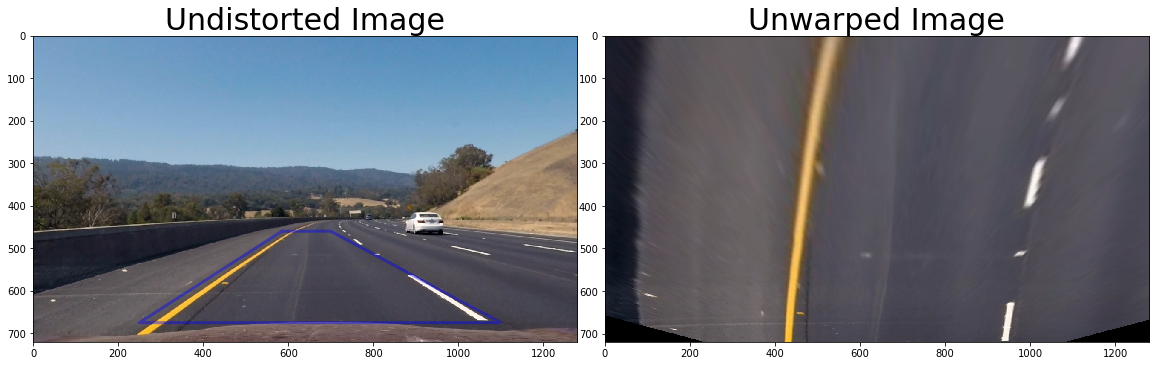

In [19]:


h,w = exampleImg_undistort.shape[:2]

# define source and destination points for transform
src = np.float32([(585,460),
                  (700,460), 
                  (250,675), 
                  (1100,675)])
dst = np.float32([(400,0),
                  (960,0),
                  (400,h),
                  (960,h)])

exampleImg_unwarp, M, Minv = unwarp(exampleImg_undistort, src, dst)

# Visualize unwarp
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(exampleImg_undistort)
x = [src[0][0],src[2][0],src[3][0],src[1][0],src[0][0]]
y = [src[0][1],src[2][1],src[3][1],src[1][1],src[0][1]]
ax1.plot(x, y, color='blue', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
ax1.set_ylim([h,0])
ax1.set_xlim([0,w])
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(exampleImg_unwarp)
ax2.set_title('Unwarped Image', fontsize=30)

# Creating Different Colorspaces Channels

Text(0.5,1,'LAB-B Channel')

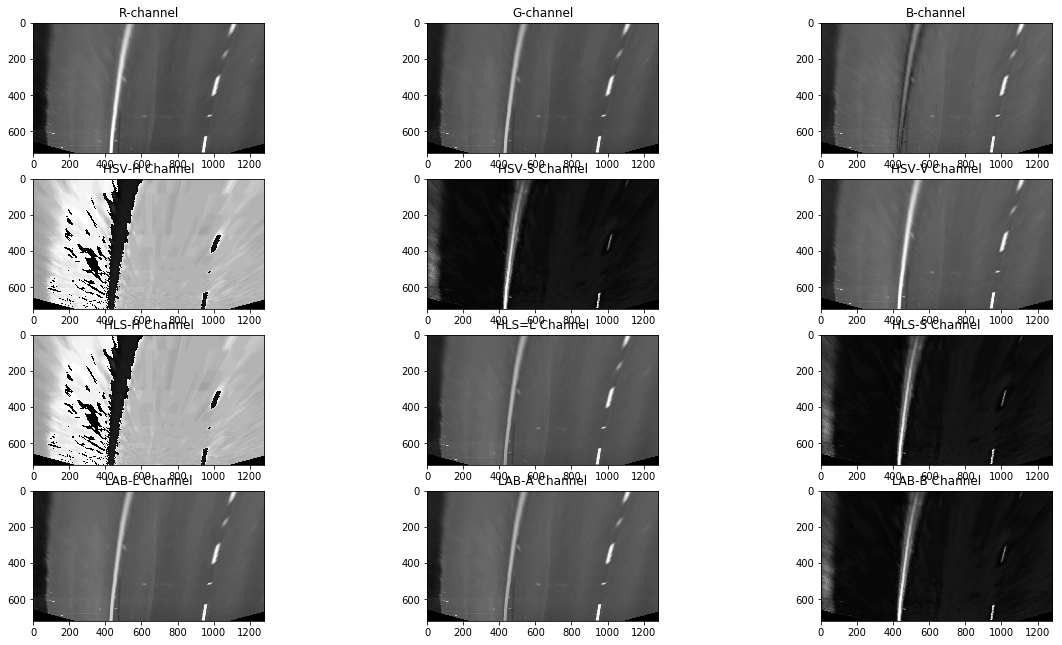

In [20]:
#First creating for RGB colorspace
exampleImg_unwarp_R=exampleImg_unwarp[:,:,0]
exampleImg_unwarp_G=exampleImg_unwarp[:,:,1]
exampleImg_unwarp_B=exampleImg_unwarp[:,:,2]
#Creating for the HSV
#first we need to convert image into HSC colorspace from RGB
exampleImg_unwarp_HSV=cv2.cvtColor(exampleImg_unwarp,cv2.COLOR_RGB2HSV)
exampleImg_unwarp_H=exampleImg_unwarp_HSV[:,:,0]
exampleImg_unwarp_S=exampleImg_unwarp_HSV[:,:,1]
exampleImg_unwarp_V=exampleImg_unwarp_HSV[:,:,2]
#creating for the HSl
#converting into HSL format
exampleImg_unwarp_HLS=cv2.cvtColor(exampleImg_unwarp,cv2.COLOR_RGB2HLS)
exampleImg_unwarp_H2=exampleImg_unwarp_HLS[:,:,0]
exampleImg_unwarp_L=exampleImg_unwarp_HLS[:,:,1]
exampleImg_unwarp_S=exampleImg_unwarp_HLS[:,:,2]
#creating for the lab format
exampleImg_unwarp_LAB = cv2.cvtColor(exampleImg_unwarp,cv2.COLOR_RGB2Lab)
exampleImg_unwarp_L2=exampleImg_unwarp_LAB[:,:,0]
exampleImg_unwarp_A=exampleImg_unwarp_HLS[:,:,1]
exampleImg_unwarp_B2=exampleImg_unwarp_HLS[:,:,2]






fig,axs=plt.subplots(4,3,figsize=(20,11))
axs=axs.flatten()
axs[0].imshow(exampleImg_unwarp_R,cmap='gray')
axs[0].set_title("R-channel")
axs[1].imshow(exampleImg_unwarp_G,cmap='gray')
axs[1].set_title("G-channel")
axs[2].set_title("B-channel")
axs[2].imshow(exampleImg_unwarp_B,cmap='gray')
axs[3].imshow(exampleImg_unwarp_H,cmap='gray')
axs[3].set_title("HSV-H Channel")
axs[4].imshow(exampleImg_unwarp_S,cmap='gray')
axs[4].set_title("HSV-S Channel")
axs[5].imshow(exampleImg_unwarp_V,cmap='gray')
axs[5].set_title("HSV-V Channel")
axs[6].imshow(exampleImg_unwarp_H2,cmap='gray')
axs[6].set_title("HLS-H Channel")
axs[7].imshow(exampleImg_unwarp_L,cmap='gray')
axs[7].set_title("HLS=L Channel")
axs[8].imshow(exampleImg_unwarp_S,cmap='gray')
axs[8].set_title("HLS-S Channel")
axs[9].imshow(exampleImg_unwarp_L2,cmap='gray')
axs[9].set_title("LAB-L Channel")
axs[10].imshow(exampleImg_unwarp_A,cmap='gray')
axs[10].set_title("LAB-A Channel")
axs[11].imshow(exampleImg_unwarp_B2,cmap='gray')
axs[11].set_title("LAB-B Channel")




# Above looking, LAB-L channel looks to do our work

# Now,let us go through some gradient thresholds

# Sobel Absolute Gradient

In [21]:
#defining a function for calculating gradient based  on the orientation
#and then taking the absolute of the gradient and then finally taking threhold
def abs_sobel_threshold(img,orient='x',min_threshold=40,max_threshold=255):
    #first convert the img into the grayscale or pur choice channel either HLS-s or LAB-B channel
    gray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)#[:,:,2]
    # 2, apply the sobel to find the gradient in either x or y orientation  
    sobel = cv2.Sobel(gray, cv2.CV_64F, orient=='x', orient=='y')
    #3,taking absolute value of sobel 
    abs_sobel=np.absolute(sobel)
    #4,Scaling to 8-bit (0 - 255) & then convert to type = np.uint8
    scaled_sobel=np.uint8(255*abs_sobel/np.max(abs_sobel))
    #5,creating a copy and applying a threshold
    binary_output=np.zeros_like(scaled_sobel)
    #6,Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
            # 6) Return this mask as your binary_output image
    binary_output[(scaled_sobel>min_threshold) & (scaled_sobel <=max_threshold) ]=1

    return binary_output
    
    


In [22]:
def visualize_transform(min_thresh,max_thresh):
    exampleImg_sobel=abs_sobel_threshold(exampleImg_unwarp,'x',min_thresh,max_thresh)
    fig,axs=plt.subplots(1,2,figsize=(20,11))
    axs[0].imshow(exampleImg_unwarp)
    axs[0].set_title("Unwarped image")
    axs[1].imshow(exampleImg_sobel,cmap='gray')
    axs[1].set_title("Sobel absolute threshold Gradient")
    

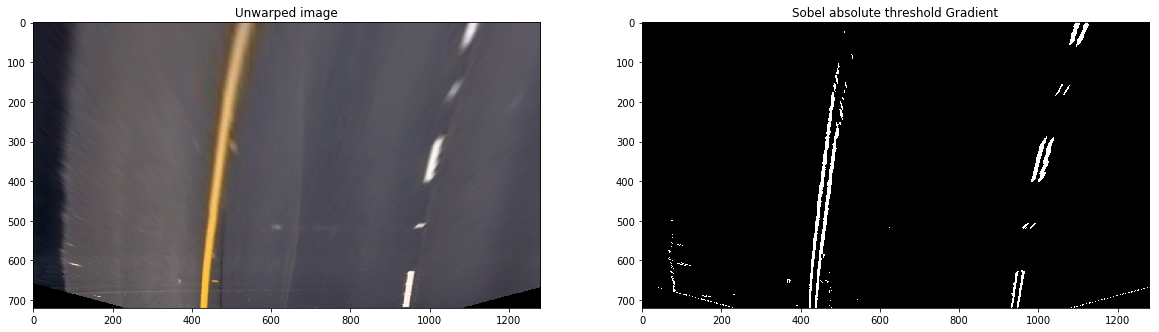

In [23]:
visualize_transform(25,255)

# Sobel Magnitude Threshold

In [24]:
#definig a function that apploes threshold in x and y direction 
#then apply magnitude on the gradient and applies min and max threshold
def mag_sobel_threshold(img,sobel_kernel=7,mag_thresh=(25,255)):
    #1,convert the img into grayscale
    gray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    #2,cal gradient in x and y one by one 
    sobelx=cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel)
    sobely=cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=sobel_kernel)
    #3,calculate the magnitude 
    mag_sobel=np.sqrt(np.square(sobelx)+np.square(sobely))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*mag_sobel/np.max(mag_sobel))
    #5,creating a copy to apply the mask
    binary_output=np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel>mag_thresh[0]) &(scaled_sobel<=mag_thresh[1])]=1
    return binary_output

    

In [25]:
#let;s see waht we got after this transform
def visualize_transform(kernel_size,min_thresh,max_thresh):
    exampleImg_sobelMag = mag_sobel_threshold(exampleImg_unwarp, kernel_size, (min_thresh, max_thresh))
    fig,axs=plt.subplots(1,2,figsize=(20,11))
    axs[0].imshow(exampleImg_unwarp)
    axs[0].set_title("Unwarped image")
    axs[1].imshow(exampleImg_sobelMag,cmap='gray')
    axs[1].set_title("Sobel Magnitude  threshold Gradient")
    


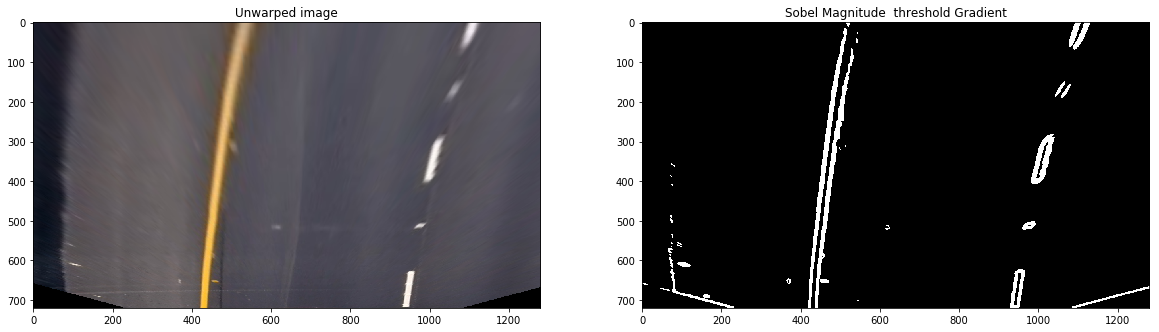

In [26]:
visualize_transform(17,35,255)

# Sobel Direction Threshold 

In [27]:
#defining a function that calculate sobel  x and y and 
#determines the direction of the gradient  and then applies a threshold
def sobel_dir_threshold(img,sobel_kernel=31,thresh=(0.1,.9)):
    #1,graryscale the image
    gray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    #2,cal gradient in x and y one by one 
    sobelx=cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel)
    sobely=cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=sobel_kernel)
    #3,take the absolute ,here we are taking the absolute 
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    #4, Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    #5,creating a copy to apply the mask
    binary_output=np.zeros_like(grad_dir)
    binary_output[(grad_dir>thresh[0])& (grad_dir<=thresh[1])]=1
    return binary_output
    
    
    
    

In [28]:
def visualize_transform(kernel_size,min_threshold,max_threshold):
    exampleImg_sobelDir = sobel_dir_threshold(exampleImg_unwarp, kernel_size, (min_threshold, max_threshold))
    fig,axs=plt.subplots(1,2,figsize=(20,11))
    axs[0].imshow(exampleImg_unwarp)
    axs[0].set_title("Unwarped image")
    axs[1].imshow(exampleImg_sobelDir,cmap='gray')
    axs[1].set_title("Sobel Direction  threshold Gradient")
    


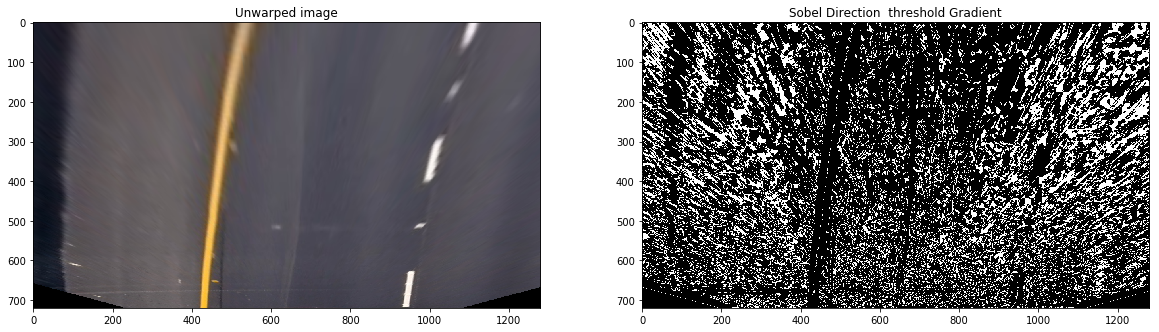

In [29]:
visualize_transform(17,0.5,.9)

# Sobel Magnitude + Sobel Direction

In [30]:
def mag_dir_threshold(mag_kernel_size,mag_min_thresh,mag_max_thresh,dir_kernel_size,dir_min_threshold,dir_max_threshold):
    exampleImg_sobelMag2=mag_sobel_threshold(exampleImg_unwarp,mag_kernel_size,(mag_min_thresh,mag_max_thresh))
    exampleImg_sobeldir2=sobel_dir_threshold(exampleImg_unwarp,dir_kernel_size,(dir_min_threshold,dir_max_threshold))
    magdir=np.zeros_like(exampleImg_sobelMag2)
    magdir[(exampleImg_sobelMag2 ==1)&(exampleImg_sobeldir2 ==1)]=1
    fig,axs=plt.subplots(1,2,figsize=(20,11))
    axs[0].imshow(exampleImg_unwarp)
    axs[0].set_title("Unwarped image")
    axs[1].imshow(magdir,cmap='gray')
    axs[1].set_title("SobelMagnitude Directionthreshold Gradient")
    

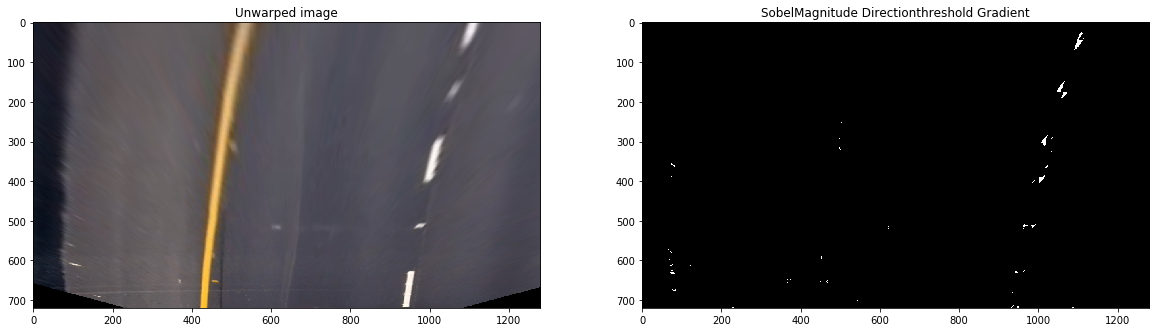

In [31]:
mag_dir_threshold(17,35,255,17,.5,.9)

# HLS-L Channel

In [32]:
# Define a function that takes the L-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_lthresh(img, thresh=(220, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hls_l = hls[:,:,1]
    #scaling the l channel
    hls_l = hls_l*(255/np.max(hls_l))
    # 2) Apply a threshold to the L channel
    binary_output = np.zeros_like(hls_l)
    binary_output[(hls_l > thresh[0]) & (hls_l <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output

In [33]:
def visualize_transform(min_threshold,max_threshold):
    exampleImg_Lthresh = hls_lthresh(exampleImg_unwarp, (min_threshold, max_threshold))
    fig,axs=plt.subplots(1,2,figsize=(20,11))
    axs[0].imshow(exampleImg_unwarp)
    axs[0].set_title("Unwarped image")
    axs[1].imshow(exampleImg_Lthresh,cmap='gray')
    axs[1].set_title("HLS-L Channel visualization")

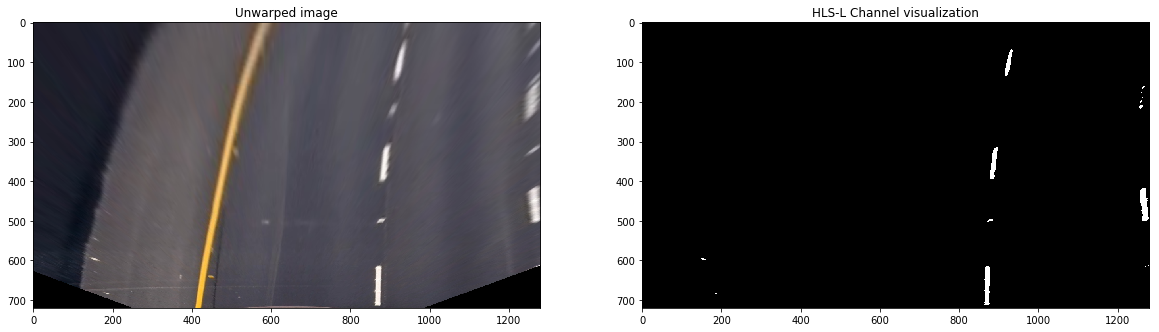

In [25]:
visualize_transform(200,255)

# LAB-B Colorspace

In [34]:
# Define a function that thresholds the B-channel of LAB
# Use exclusive lower bound (>) and inclusive upper (<=), OR the results of the thresholds (B channel should capture
# yellows)
def lab_bthresh(img, thresh=(200,255)):
    # 1) Convert to LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    lab_b = lab[:,:,2]
    # don't normalize if there are no yellows in the image
    if np.max(lab_b) > 175:
        lab_b = lab_b*(255/np.max(lab_b))
    # 2) Apply a threshold to the L channel
    binary_output = np.zeros_like(lab_b)
    binary_output[((lab_b > thresh[0]) & (lab_b <= thresh[1]))] = 1
    # 3) Return a binary image of threshold result
    return binary_output

In [35]:
def visualize_transform(min_threshold,max_threshold):
    exampleImg_Bthresh = lab_bthresh(exampleImg_unwarp, (min_threshold, max_threshold))
    fig,axs=plt.subplots(1,2,figsize=(20,11))
    axs[0].imshow(exampleImg_unwarp)
    axs[0].set_title("Unwarped image")
    axs[1].imshow(exampleImg_Bthresh,cmap='gray')
    axs[1].set_title("LAB-B Thresh")

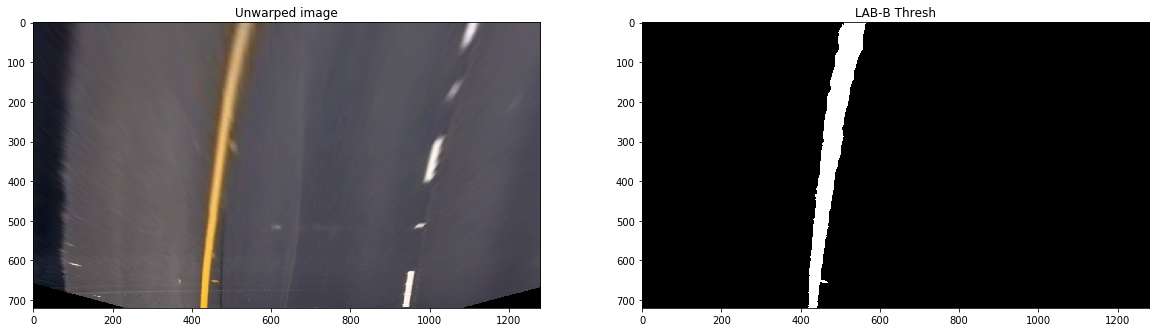

In [36]:
visualize_transform(180,255)

# Now ,i am going to define a pipeline for all the images where we read the raw images and will return the lanes identified

In [37]:
def pipeline(img):
    #1,first we are going to perform undistortion
    img_undistort=undistort(img)
    #2,perspective transform
    img_unwarp, M, Minv = unwarp(img_undistort, src, dst)
    #fit best to combination of color and gradients to detect best fit  lane
    img_sobelmag=mag_sobel_threshold(img_unwarp)
    img_STHRESH=hls_lthresh(img_unwarp)
    img_BTHRESH=lab_bthresh(img_unwarp)
    binary_output=np.zeros_like(img_BTHRESH)
    binary_output[(img_STHRESH ==1) | (img_BTHRESH ==1)]=1#we are using or here as one is to detect for white and one is for yellow so we need to incude both
    return binary_output,Minv

# Running this pipeline on all the images 

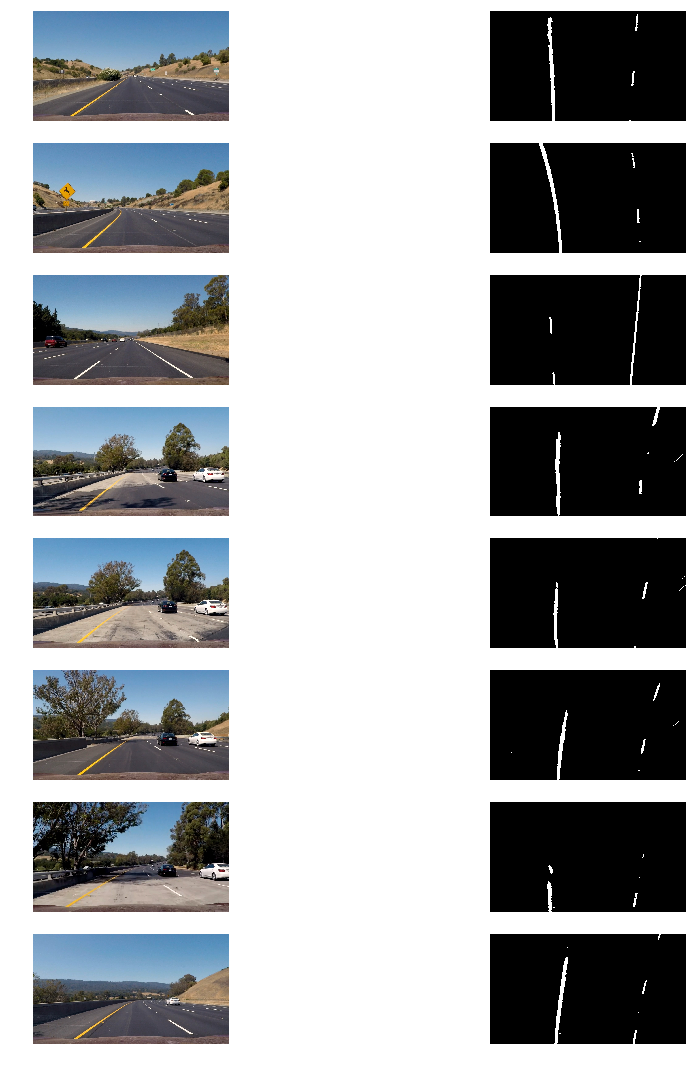

In [38]:
#list of all images from test_images folder
images=glob.glob('./test_images/*.jpg')
fig,axs=plt.subplots(len(images),2,figsize=(15,19))
axs=axs.flatten()
i=0
for im in images:
    img=cv2.imread(im)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    bin_img,Minv=pipeline(img)
    axs[i].imshow(img)
    axs[i].axis('off')
    i+=1
    axs[i].imshow(bin_img,cmap='gray')
    axs[i].axis('off')
    i+=1


# Sliding Window 

In [39]:
#defining a function to create binary image with window sliding
def sliding_window_polyfit(img):
    # Lane lines are likely to be mostly vertical nearest to the car
    # Take a histogram of the bottom half of the image
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    quarter_point = np.int(midpoint//2)
    #choose lane lines where pixels have highers values or peaks
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    #leftx_base = np.argmax(histogram[quarter_point:midpoint])+quarter_point
    #rightx_base = np.argmax(histogram[midpoint:(quarter_point+midpoint)]) + midpoint

    #print(leftx_base)
    #print(rightx_base)
    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 40
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Rectangle data for visualization
    rectangle_data = []
    
    
    #iteraate through each window to track curvature
    for window in range(nwindows):
        #1,identify window boundary x and y ,rigth or lefft
        #first to adjust our window according to height 
        win_low=img.shape[0]-(window+1)*window_height
        win_high=img.shape[0]-window*window_height
        win_xleft_low=leftx_current -margin
        win_xleft_high=leftx_current + margin
        win_xright_low=rightx_current -margin
        win_xright_high=rightx_current + margin
        #these all are points that conclude one small rectangle
        rectangle_data.append((win_low,win_high,win_xleft_low,win_xleft_high,win_xright_low,win_xright_high))
        
        #find out which activated pixels from nonzeroy and nonzerox above actually fall into the window.
        
        good_left_inds= ((nonzeroy >= win_low) & (nonzeroy < win_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    
        good_right_inds= ((nonzeroy >= win_low) & (nonzeroy < win_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    
        #append these indices to lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    #2, Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    #3, Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    left_fit, right_fit = (None, None)
    #4, Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    visualization_data = (rectangle_data, histogram)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data

            

    


(720, 0)

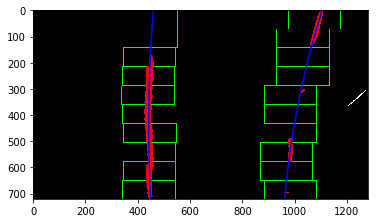

In [42]:
# visualize the result on example image
exampleImg = cv2.imread('./test_images/test4.jpg')
exampleImg = cv2.cvtColor(exampleImg, cv2.COLOR_BGR2RGB)
exampleImg_bin, Minv = pipeline(exampleImg)
    
left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data = sliding_window_polyfit(exampleImg_bin)

rectangles = visualization_data[0]
histogram = visualization_data[1]

# Create an output image to draw on and  visualize the result
out_img = np.uint8(np.dstack((exampleImg_bin, exampleImg_bin, exampleImg_bin))*255)
# Generate x and y values for plotting
ploty = np.linspace(0, exampleImg_bin.shape[0]-1, exampleImg_bin.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
for rect in rectangles:
# Draw the windows on the visualization image
    cv2.rectangle(out_img,(rect[2],rect[0]),(rect[3],rect[1]),(0,255,0), 2) 
    cv2.rectangle(out_img,(rect[4],rect[0]),(rect[5],rect[1]),(0,255,0), 2) 
# Identify the x and y positions of all nonzero pixels in the image
nonzero = exampleImg_bin.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [255, 0, 0]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='blue')
plt.plot(right_fitx, ploty, color='blue')
plt.xlim(0, 1280)
plt.ylim(720, 0)


(0, 1280)

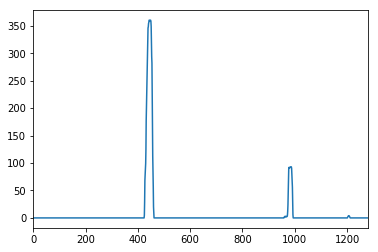

In [41]:
plt.plot(histogram)
plt.xlim(0, 1280)

In [43]:
def polyfit_using_prev_fit(binary_warped, left_fit_prev, right_fit_prev):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 80
    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] - margin)) & 
                      (nonzerox < (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] - margin)) & 
                       (nonzerox < (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit_new, right_fit_new = (None, None)
    if len(leftx) != 0:
        # Fit a second order polynomial to each
        left_fit_new = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit_new = np.polyfit(righty, rightx, 2)
    return left_fit_new, right_fit_new, left_lane_inds, right_lane_inds


...


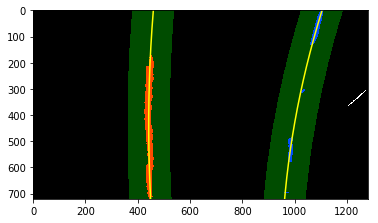

In [44]:
exampleImg2 = cv2.imread('./test_images/test4.jpg')
exampleImg2 = cv2.cvtColor(exampleImg2, cv2.COLOR_BGR2RGB)
exampleImg2_bin, Minv = pipeline(exampleImg2)   
margin = 80

left_fit2, right_fit2, left_lane_inds2, right_lane_inds2 = polyfit_using_prev_fit(exampleImg2_bin, left_fit, right_fit)

# Generate x and y values for plotting
ploty = np.linspace(0, 719,num=720 )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
left_fitx2 = left_fit2[0]*ploty**2 + left_fit2[1]*ploty + left_fit2[2]
right_fitx2 = right_fit2[0]*ploty**2 + right_fit2[1]*ploty + right_fit2[2]

# Create an image to draw on and an image to show the selection window
out_img = np.uint8(np.dstack((exampleImg2_bin, exampleImg2_bin, exampleImg2_bin))*255)
window_img = np.zeros_like(out_img)

# Color in left and right line pixels
nonzero = exampleImg2_bin.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_inds2], nonzerox[left_lane_inds2]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds2], nonzerox[right_lane_inds2]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area (OLD FIT)
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx2, ploty, color='yellow')
plt.plot(right_fitx2, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
print('...')

# Radius of Curvature
Rcurve=(pow((1+(2Ay+B)**2),3/2))/2A

# The yy values of your image increase from top to bottom, so if, for example, you wanted to measure
the radius of curvature closest to your vehicle, you could evaluate the formula above at the yy value 
corresponding to the bottom of your image, or in Python, at yvalue = image.shape[0].

In [47]:
# defining a function to determine radius of curvature and distance from lane center 
# based on binary image, polynomial fit, and left and right lane pixel indices
def cur_rad_center_dist(bin_img, l_fit, r_fit, l_lane_inds, r_lane_inds):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 3/100 # meters per pixel in y dimension
    xm_per_pix = 3.7/400 # meters per pixel in x dimension
    #initializing the leftcurverad,rightcurverad and centerdist as 0,0,0
    left_curverad, right_curverad, center_dist = (0, 0, 0)
    #defining yvalue where i have to choose radius of curvature  
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    #choosing maximum of yvalue at the very bottom of the image 
    y_eval=np.max(ploty)
    
    #again repeating the same steps to find the nonzero x and y pixels 
    nonzero = bin_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ## Again, extract left and right line pixel positions
    leftx = nonzerox[l_lane_inds]
    lefty = nonzeroy[l_lane_inds] 
    rightx = nonzerox[r_lane_inds]
    righty = nonzeroy[r_lane_inds]
    
    if len(leftx) != 0 and len(rightx) != 0:
        # Fit new polynomials to x,y in world space  in the meter
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        # # Calculation of R_curve (radius of curvature) in meter
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        
    # position of car with respect to center is image x midpoint - mean of l_fit and r_fit intercepts 
    if r_fit is not None and l_fit is not None:
        car_position = bin_img.shape[1]/2
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        lane_center_position = (r_fit_x_int + l_fit_x_int) /2
        center_dist = (car_position - lane_center_position) * xm_per_pix
    return left_curverad, right_curverad, center_dist


In [48]:
left_rad, right_rad, d_center = cur_rad_center_dist(exampleImg_bin, left_fit, right_fit, left_lane_inds, right_lane_inds)

print('Left Radius:', left_rad, 'm')
print('Right Radius' , right_rad, 'm')
print('Car position from lane center:', d_center, 'm')

Left Radius: 525.426896424 m
Right Radius 315.174592204 m
Car position from lane center: -0.607232190818 m


# Drawing the image back onto the Original Image

In [49]:
#defining a function to draw bin_img back on the original image 
def draw_lane(ori_img,binary_img,l_fit,r_fit,Minv):
    newimg=np.copy(ori_img)
    if l_fit is None or r_fit is None:
        return ori_img
    
     # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    h,w = binary_img.shape
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image(0,719)
    #generating x and y values for plotting
    left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]
    
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
     # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    # Combine the result with the original image
    result = cv2.addWeighted(newimg, 1, newwarp, 0.5, 0)
    return result
    
    
    
    
    

    

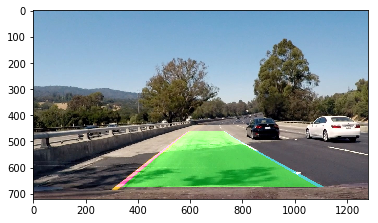

In [50]:
exampleImg_out1 = draw_lane(exampleImg, exampleImg_bin, left_fit, right_fit, Minv)
plt.imshow(exampleImg_out1)

# Showing Radius Curve and position of car from center info onto the original image 

In [51]:
def draw_info(original_img, curv_rad, center_dist):
    newimg = np.copy(original_img)
    h = newimg.shape[0]
    #font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Curve radius: ' + '{:04.2f}'.format(curv_rad) + 'm'
    cv2.putText(newimg, text, (40,70), cv2.FONT_HERSHEY_DUPLEX, 1.5, (200,255,155), 2, cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(newimg, text, (40,120), cv2.FONT_HERSHEY_DUPLEX, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return newimg

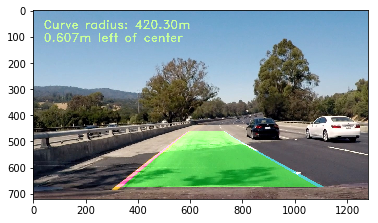

In [53]:
exampleImg_out2 = draw_info(exampleImg_out1, (left_rad+right_rad)/2, d_center)
plt.imshow(exampleImg_out2)

In [54]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #number of detected pixels
        self.px_count = None
    def add_fit(self, fit, inds):
        # add a found fit to the line, up to n
        if fit is not None:
            if self.best_fit is not None:
                # if we have a best fit, see how this new fit compares
                self.diffs = abs(fit-self.best_fit)
            if (self.diffs[0] > 0.001 or \
               self.diffs[1] > 1.0 or \
               self.diffs[2] > 100.) and \
               len(self.current_fit) > 0:
                # bad fit! abort! abort! ... well, unless there are no fits in the current_fit queue, then we'll take it
                self.detected = False
            else:
                self.detected = True
                self.px_count = np.count_nonzero(inds)
                self.current_fit.append(fit)
                if len(self.current_fit) > 5:
                    # throw out old fits, keep newest n
                    self.current_fit = self.current_fit[len(self.current_fit)-5:]
                self.best_fit = np.average(self.current_fit, axis=0)
        # or remove one from the history, if not found
        else:
            self.detected = False
            if len(self.current_fit) > 0:
                # throw out oldest fit
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            if len(self.current_fit) > 0:
                # if there are still any fits in the queue, best_fit is their average
                self.best_fit = np.average(self.current_fit, axis=0)


In [55]:
def process_image(img):
    new_img = np.copy(img)
    img_bin, Minv = pipeline(new_img)
    
    # if both left and right lines were detected last frame, use polyfit_using_prev_fit, otherwise use sliding window
    if not l_line.detected or not r_line.detected:
        l_fit, r_fit, l_lane_inds, r_lane_inds, _ = sliding_window_polyfit(img_bin)
    else:
        l_fit, r_fit, l_lane_inds, r_lane_inds = polyfit_using_prev_fit(img_bin, l_line.best_fit, r_line.best_fit)
        
    # invalidate both fits if the difference in their x-intercepts isn't around 350 px (+/- 100 px)
    if l_fit is not None and r_fit is not None:
        # calculate x-intercept (bottom of image, x=image_height) for fits
        h = img.shape[0]
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        x_int_diff = abs(r_fit_x_int-l_fit_x_int)
        if abs(350 - x_int_diff) > 100:
            l_fit = None
            r_fit = None
            
    l_line.add_fit(l_fit, l_lane_inds)
    r_line.add_fit(r_fit, r_lane_inds)
    
    # draw the current best fit if it exists
    if l_line.best_fit is not None and r_line.best_fit is not None:
        img_out1 = draw_lane(new_img, img_bin, l_line.best_fit, r_line.best_fit, Minv)
        rad_l, rad_r, d_center = cur_rad_center_dist(img_bin, l_line.best_fit, r_line.best_fit, 
                                                               l_lane_inds, r_lane_inds)
        img_out = draw_info(img_out1, (rad_l+rad_r)/2, d_center)
    else:
        img_out = new_img
    
    diagnostic_output = False
    if diagnostic_output:
        # put together multi-view output
        diag_img = np.zeros((720,1280,3), dtype=np.uint8)
        
        # original output (top left)
        diag_img[0:360,0:640,:] = cv2.resize(img_out,(640,360))
        
        # binary overhead view (top right)
        img_bin = np.dstack((img_bin*255, img_bin*255, img_bin*255))
        resized_img_bin = cv2.resize(img_bin,(640,360))
        diag_img[0:360,640:1280, :] = resized_img_bin
        
        # overhead with all fits added (bottom right)
        img_bin_fit = np.copy(img_bin)
        for i, fit in enumerate(l_line.current_fit):
            img_bin_fit = plot_fit_onto_img(img_bin_fit, fit, (20*i+100,0,20*i+100))
        for i, fit in enumerate(r_line.current_fit):
            img_bin_fit = plot_fit_onto_img(img_bin_fit, fit, (0,20*i+100,20*i+100))
        img_bin_fit = plot_fit_onto_img(img_bin_fit, l_line.best_fit, (255,255,0))
        img_bin_fit = plot_fit_onto_img(img_bin_fit, r_line.best_fit, (255,255,0))
        diag_img[360:720,640:1280,:] = cv2.resize(img_bin_fit,(640,360))
        
        # diagnostic data (bottom left)
        color_ok = (200,255,155)
        color_bad = (255,155,155)
        font = cv2.FONT_HERSHEY_DUPLEX
        if l_fit is not None:
            text = 'This fit L: ' + ' {:0.6f}'.format(l_fit[0]) + \
                                    ' {:0.6f}'.format(l_fit[1]) + \
                                    ' {:0.6f}'.format(l_fit[2])
        else:
            text = 'This fit L: None'
        cv2.putText(diag_img, text, (40,380), font, .5, color_ok, 1, cv2.LINE_AA)
        if r_fit is not None:
            text = 'This fit R: ' + ' {:0.6f}'.format(r_fit[0]) + \
                                    ' {:0.6f}'.format(r_fit[1]) + \
                                    ' {:0.6f}'.format(r_fit[2])
        else:
            text = 'This fit R: None'
        cv2.putText(diag_img, text, (40,400), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Best fit L: ' + ' {:0.6f}'.format(l_line.best_fit[0]) + \
                                ' {:0.6f}'.format(l_line.best_fit[1]) + \
                                ' {:0.6f}'.format(l_line.best_fit[2])
        cv2.putText(diag_img, text, (40,440), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Best fit R: ' + ' {:0.6f}'.format(r_line.best_fit[0]) + \
                                ' {:0.6f}'.format(r_line.best_fit[1]) + \
                                ' {:0.6f}'.format(r_line.best_fit[2])
        cv2.putText(diag_img, text, (40,460), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Diffs L: ' + ' {:0.6f}'.format(l_line.diffs[0]) + \
                             ' {:0.6f}'.format(l_line.diffs[1]) + \
                             ' {:0.6f}'.format(l_line.diffs[2])
        if l_line.diffs[0] > 0.001 or \
           l_line.diffs[1] > 1.0 or \
           l_line.diffs[2] > 100.:
            diffs_color = color_bad
        else:
            diffs_color = color_ok
        cv2.putText(diag_img, text, (40,500), font, .5, diffs_color, 1, cv2.LINE_AA)
        text = 'Diffs R: ' + ' {:0.6f}'.format(r_line.diffs[0]) + \
                             ' {:0.6f}'.format(r_line.diffs[1]) + \
                             ' {:0.6f}'.format(r_line.diffs[2])
        if r_line.diffs[0] > 0.001 or \
           r_line.diffs[1] > 1.0 or \
           r_line.diffs[2] > 100.:
            diffs_color = color_bad
        else:
            diffs_color = color_ok
        cv2.putText(diag_img, text, (40,520), font, .5, diffs_color, 1, cv2.LINE_AA)
        text = 'Good fit count L:' + str(len(l_line.current_fit))
        cv2.putText(diag_img, text, (40,560), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Good fit count R:' + str(len(r_line.current_fit))
        cv2.putText(diag_img, text, (40,580), font, .5, color_ok, 1, cv2.LINE_AA)
        
        img_out = diag_img
    return img_out

In [68]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

l_line = Line()
r_line = Line()
#my_clip.write_gif('test.gif', fps=12)
video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4')#.subclip(22,26)
processed_video = video_input1.fl_image(process_image)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4



 24%|██▍       | 303/1261 [01:05<03:35,  4.44it/s]


 48%|████▊     | 605/1261 [02:15<02:39,  4.12it/s]


 72%|███████▏  | 907/1261 [03:25<01:21,  4.33it/s]


 96%|█████████▌| 1206/1261 [04:36<00:13,  4.22it/s]


100%|█████████▉| 1260/1261 [04:48<00:00,  4.38it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 2min 42s, sys: 1.11 s, total: 2min 43s
Wall time: 4min 51s
